For the various architectural experiments, we constructed the dataset using different cutoff radius values: {2.0, 4.0, 8.0} Å. This notebook begins by visualizing a randomly selected crystal system, then examines the distribution of all lattice parameters across the entire dataset, and finally plots a stacked histogram (train/validation/test) of neighbors for each cutoff radius.

In [1]:
from pathlib import Path
import random
import numpy as np
import pandas as pd

from torch_geometric.loader import DataLoader

import matplotlib as mpl
import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from ase import Atom, Atoms
# from ase.neighborlist import neighbor_list
from ase.visualize.plot import plot_atoms

from utils import (
    build_data,
    load_data,
    train_valid_test_split
)

seed = 0  # this was the default used in the experimentations
random.seed(seed)
np.random.seed(seed)

palette = ['#2876B2', '#F39957', '#67C7C2', '#C86646']
datasets = ['train', 'valid', 'test']
colors = dict(zip(datasets, palette[:-1]))
cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', [palette[k] for k in [0,2,1]])
csv_file = Path("data/data.csv")

data_df, species = load_data(csv_file)

# Visualizing an example Crystal Structure

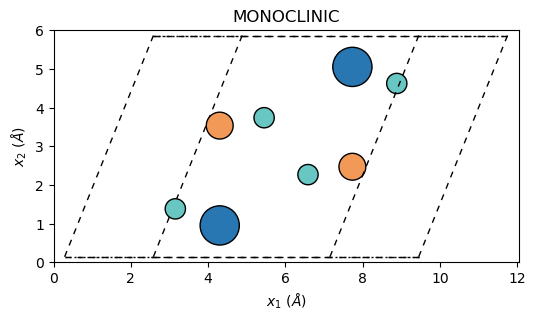

CPU times: user 14.9 s, sys: 1.29 s, total: 16.2 s
Wall time: 655 ms


In [2]:
%%time

i = 100  # change this number

struct = data_df.iloc[i]['structure']
symbols = np.unique(list(struct.symbols))
z = dict(zip(symbols, range(len(symbols))))

fig, ax = plt.subplots(figsize=(6,5))
norm = plt.Normalize(vmin=0, vmax=len(symbols)-1)
color = [mpl.colors.to_hex(k) for k in cmap(norm([z[j] for j in list(struct.symbols)]))]
plot_atoms(struct, ax, radii=0.25, colors=color, rotation=('0x,90y,0z'))

ax.set_xlabel(r'$x_1\ (\AA)$')
ax.set_ylabel(r'$x_2\ (\AA)$')
ax.set_title(f"{data_df['crystal_system'][i].upper()}")

plt.savefig("../figures/crystal_example.png", dpi=300)
plt.show()

# Distribution of Lattice Parameters across the entire dataset

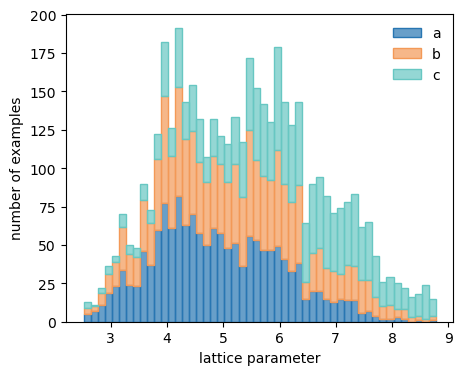

Average lattice parameter (a/b/c): 4.91 / 5.26 / 6.52


In [3]:
def get_lattice_parameters(df):
    """Lattice parameter statistics."""
    a = [entry.structure.cell.cellpar()[:3] for entry in df.itertuples()]
    return np.stack(a)

a = get_lattice_parameters(data_df)

fig, ax = plt.subplots(1,1, figsize=(5,4))
b = 0.
bins = 50

for d, c, n in zip(['a', 'b', 'c'], colors.values(), [a[:,0], a[:,1], a[:,2]]):
    color = [int(c.lstrip('#')[i:i+2], 16)/255. for i in (0,2,4)]
    y, bins, _ = ax.hist(n, bins=bins, fc=color+[0.7], ec=color, bottom=b, label=d)
    b += y

ax.set_xlabel('lattice parameter')
ax.set_ylabel('number of examples')
ax.legend(frameon=False)

plt.savefig("../figures/lattice_statistics.png", dpi=300)
plt.show()

print(f"Average lattice parameter (a/b/c): {a[:,0].mean():.2f} / {a[:,1].mean():.2f} / {a[:,2].mean():.2f}")

# Stacked Histogram of Neighbors for each Cutoff Radius

For 2.0 Å, average number of neighbors (train / valid / test): 1.64 / 1.51 / 1.62 

For 4.0 Å, average number of neighbors (train / valid / test): 15.66 / 15.86 / 16.18 

For 8.0 Å, average number of neighbors (train / valid / test): 121.73 / 119.86 / 125.82 



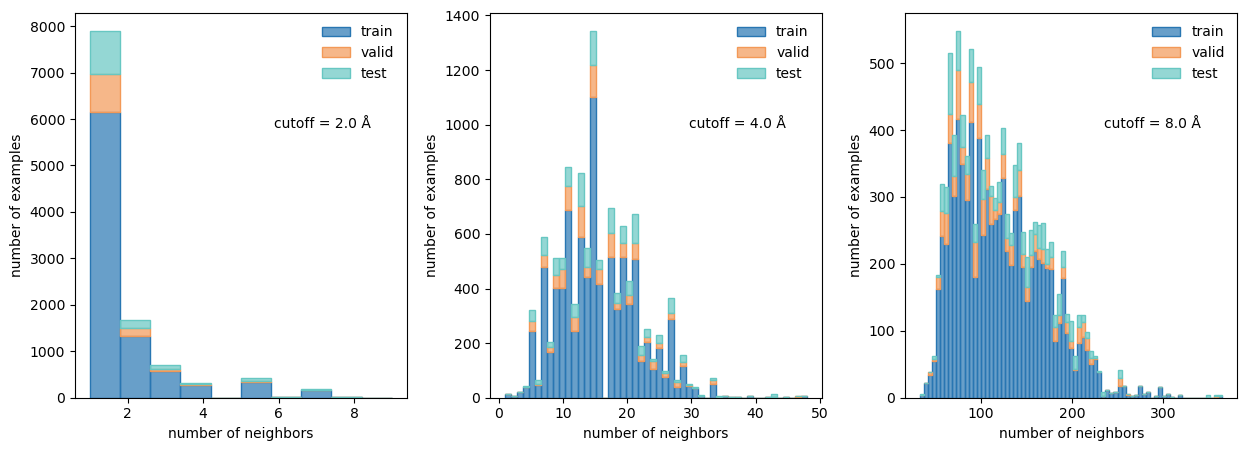

CPU times: user 1h 16min 47s, sys: 5min 26s, total: 1h 22min 14s
Wall time: 1min 22s


In [4]:
%%time

def get_neighbors(df, idx):
    """Calculate average number of neighbors."""
    n = []
    for entry in df.iloc[idx].itertuples():
        N = entry.data.pos.shape[0]
        n.extend(len((entry.data.edge_index[0] == i).nonzero()) for i in range(N))
    return np.array(n)

def rmax_data(r_max):
    """Calculate neighbor statistics for train/val/test split based on cutoff distance."""

    csv_file = Path("data/data.csv")
    df, species = load_data(csv_file)
    df["data"] = df.apply(lambda x: build_data(x, r_max), axis=1)

    idx_train, idx_valid, idx_test = train_valid_test_split(
        df, species, valid_size=0.1, test_size=0.1, seed=0
    )

    train_loader = DataLoader(
        df.iloc[idx_train]["data"].values,
        batch_size=8,
        shuffle=True,
    )
    valid_loader = DataLoader(
        df.iloc[idx_valid]["data"].values, batch_size=8
    )
    test_loader = DataLoader(
        df.iloc[idx_test]["data"].values, batch_size=8
    )

    n_train = get_neighbors(df, idx_train)
    n_valid = get_neighbors(df, idx_valid)
    n_test = get_neighbors(df, idx_test)

    return n_train, n_valid, n_test


fig, ax = plt.subplots(1,3, figsize=(15,5))

bin_list = [10, 50, 75]

for i, cutoff in enumerate([2.0, 4.0, 8.0]):
    b = 0.
    bins = bin_list[i]
    n_train, n_valid, n_test = rmax_data(cutoff)

    for (d, c), n in zip(colors.items(), [n_train, n_valid, n_test]):
        color = [int(c.lstrip('#')[i:i+2], 16)/255. for i in (0,2,4)]
        y, bins, _, = ax[i].hist(n, bins=bins, fc=color+[0.7], ec=color, bottom=b, label=d)
        b += y
    ax[i].set_xlabel('number of neighbors')
    ax[i].set_ylabel('number of examples')
    ax[i].legend(frameon=False)
    ax[i].annotate(f"cutoff = {cutoff} Å", (0.6, 0.7), xycoords="axes fraction")

    print(f"For {cutoff} Å, average number of neighbors (train / valid / test): {n_train.mean():.2f} / {n_valid.mean():.2f} / {n_test.mean():.2f} \n")


plt.subplots_adjust(wspace=0.25)

plt.savefig("../figures/cutoff_neighbors.png", dpi=300)
plt.show()